# Tappy Keystroke Data with Parkinson’s Patients

Tappy è un'applicazione per la registrazione delle sequenze di battitura.

Nel progetto verrà analizzato un dataset contenente i registri delle sequenze di tasti raccolti da oltre 200 soggetti, con e senza il morbo di Parkinson, che hanno digitato normalmente sul proprio computer per un periodo di settimane o mesi, senza supervisione.

L'analisi si compone di una parte di acquisizione e pulizia dei dati, e di un'altra parte per l'utilizzo di modelli di machine learning, che hanno lo scopo di indicare che l'interazione con la tastiera può essere usata per rilevare particolarità nel movimento delle dita nelle prime fasi del morbo di Parkinson.

Il dataset è stato scaricato dal link https://www.kaggle.com/datasets/valkling/tappy-keystroke-data-with-parkinsons-patients. È suddiviso a sua volta in due dataset: il primo è fornito direttamente dal software Tappy, quindi include dati come tempo di pressione e rilascio dei tasti e movimenti ottenuti dividendo virtualmente la tastiera in una zona di destra e una di sinistra; il secondo contiene informazioni sui pazienti (quali anno di nascita, sesso, e attributi riguardanti il morbo di Parkinson qualora il paziente ne fosse affetto). Tra questi, l'attributo più importante è "Parkinsons", che verrà usata come predizione per la classificazione binaria.

Al dataset è associato un articolo preso dal sito https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0188226#sec008, in cui viene spiegato il significato degli attributi. Da questo paper abbiamo tratto informazioni utili per l'acquisizione dei dati.

## Indice

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

## Caricamento dataset

In [6]:
# Creation of user_df, a DataFrame with informations about Archived Users

users = []

for filepath in glob.iglob('Users/Archived users/*.txt'):
    users.append(filepath[-14:-4])

user_number = len(users)    # number of users

user_df = pd.DataFrame(users, columns = ["Users"])

# Create columns

col_index = []

file = open('Users/Archived users/User_' + str(users[0]) + ".txt")
lines = file.read().split("\n")
ll = len(lines)

for l in range(ll-1):
    sl = lines[l].split(": ", 1)
    col_index.append(sl[0])

# Create values

values_list = []
values = []

for i in range(user_number):
    file = open('Users/Archived users/User_' + str(users[i]) + ".txt")
    lines = file.read().split("\n")
    for l in range(ll-1):
        sl = lines[l].split(": ", 1)
        v = sl[1]
        values.append(v)
    values_list.append(values)
    values = []

# Insert values in user_df

value_df = pd.DataFrame(values_list, columns = col_index)

user_df = pd.concat([user_df, value_df], axis = 1)

# Creation of tappydata_df, a DataFrame with informations about Archived Data

tappydata = []

for filepath in glob.iglob('Data/Tappy Data/*.txt'):
    file = open(filepath)
    lines = file.read().split("\n")
    for l in range(len(lines)-1):
        x = lines[l]
        x = x.split("\t")
        tappydata.append(x)

tappydata_df = pd.DataFrame(tappydata, columns = ["Users", "Date", "Datetime", "TapPosition", "Hold", "Movement", "Latency", "Flight", "*"])

# Merge user_df with tappydata_df, joining on the attribute "Users"

all_userdata_df = pd.merge(tappydata_df, user_df, how='inner', left_on='Users', right_on='Users')

## Pulizia dataset

Tra i pazienti con il morbo di Parkinson consideriamo solo quelli nelle prime fasi della malattia. Per questo si mantengono solo i pazienti con impatto lieve, oltre a quelli non malati.

Sempre facendo fede all'articolo di riferimento, sono stati eliminati dall'analisi anche i pazienti che assumevano Levadopa.

Inoltre sono stati rimossi i pazienti di cui sono stati analizzati troppi o troppi pochi dati, con lo scopo di avere un insieme di dati più consistente e bilanciato.

Dopo la pulizia di questi attributi, sono state cancellate le colonne ritenute meno utili per l'addestramento.

Infine si prendono in esame solo gli utenti di cui si conosce l'anno di nascita, poiché l'età è un attributo determinante e fortemente correlato alla positività al morbo di Parkinson.

In [7]:
all_userdata_df = all_userdata_df[all_userdata_df.Impact != "Severe"]
all_userdata_df = all_userdata_df[all_userdata_df.Impact != "Medium"]

all_userdata_df = all_userdata_df[all_userdata_df.Levadopa == "False"]

counts = all_userdata_df['Users'].value_counts()
#avg = all_userdata_df.shape[0] / len(counts)
#print(avg)  # numero medio di tap per ogni utente

#counts.plot(kind = "hist")
#counts.plot(kind = "hist", range = [0, 50])

# togliere da dopo 1000 a 100000

all_userdata_df = all_userdata_df[all_userdata_df['Users'].isin(counts[counts > 1000].index)]
all_userdata_df = all_userdata_df[all_userdata_df['Users'].isin(counts[counts < 100000].index)]

#all_userdata_df.head()

# non leviamo i tap con lo spazio !!!


#all_userdata_df = all_userdata_df.drop(["Users", "Date", "Datetime", "Flight", "*", "Tremors", "DiagnosisYear", "Sided", "UPDRS", "Impact", "Levadopa", "DA", "MAOB", "Other"], axis=1)

all_userdata_df.drop(all_userdata_df.loc[all_userdata_df['BirthYear']==''].index, inplace=True)

# completata la pulizia

In [26]:
#print(len(all_userdata_df.loc[158453]))



counts_Rhold = all_userdata_df[all_userdata_df["Latency"] == '07YQSGN9BMVK']
print(counts_Rhold)
counts_Rhold.head()
# all_userdata_df.drop(all_userdata_df.loc[all_userdata_df['Latency']=='01CAXCJIKLYM'].index, inplace=True)
# all_userdata_df.drop(all_userdata_df.loc[all_userdata_df['Latency']=='EF9XEFXPBN'].index, inplace=True)
# all_userdata_df.drop(all_userdata_df.loc[all_userdata_df['Latency']=='01IDYIDJBAXF'].index, inplace=True)
# all_userdata_df.drop(all_userdata_df.loc[all_userdata_df['Latency']=='K2VMDST8HC'].index, inplace=True)
# all_userdata_df.drop(all_userdata_df.loc[all_userdata_df['Latency']=='LSQWWDXEYO'].index, inplace=True)
# all_userdata_df.drop(all_userdata_df.loc[all_userdata_df['Latency']=='04LSQWWDXEYO'].index, inplace=True)
# all_userdata_df.drop(all_userdata_df.loc[all_userdata_df['Latency']=='0NMMGWRY6SO'].index, inplace=True)

# all_userdata_df.drop(all_userdata_df.loc[all_userdata_df['Latency']=='08:27:14.043'].index, inplace=True)
# all_userdata_df.drop(all_userdata_df.loc[all_userdata_df['Latency']=='01QCFNDCZPQH'].index, inplace=True)
# all_userdata_df.drop(all_userdata_df.loc[all_userdata_df['Latency']=='09:11:16.406'].index, inplace=True)
# all_userdata_df.drop(all_userdata_df.loc[all_userdata_df['Latency']=='S9C3TTX3NE'].index, inplace=True)
# all_userdata_df.drop(all_userdata_df.loc[all_userdata_df['Latency']=='SOP2REQFUH'].index, inplace=True)

# all_userdata_df.drop(all_userdata_df.loc[all_userdata_df['Latency']=='05SOP2REQFUH'].index, inplace=True)
# all_userdata_df.drop(all_userdata_df.loc[all_userdata_df['Latency']=='0613.SOP2REQFUH'].index, inplace=True)
# all_userdata_df.drop(all_userdata_df.loc[all_userdata_df['Latency']=='04TL2XHTLK1T'].index, inplace=True)
# all_userdata_df.drop(all_userdata_df.loc[all_userdata_df['Latency']=='12:12:50.477'].index, inplace=True)
# all_userdata_df.drop(all_userdata_df.loc[all_userdata_df['Latency']=='0218.VSBEPFSFWK'].index, inplace=True)

# all_userdata_df.drop(all_userdata_df.loc[all_userdata_df['Latency']=='21:38:52.695'].index, inplace=True)
# all_userdata_df.drop(all_userdata_df.loc[all_userdata_df['Latency']=='07YQSGN9BMVK'].index, inplace=True)





              Users    Date      Datetime TapPosition    Hold Movement  \
8596099  YQSGN9BMVK  170213  08:01:13.852           R  0084.0       LR   

              Latency  Flight * BirthYear  ... Parkinsons Tremors  \
8596099  07YQSGN9BMVK  170213        1948  ...      False   False   

        DiagnosisYear Sided       UPDRS   Impact Levadopa     DA   MAOB  Other  
8596099        ------  None  Don't know   ------    False  False  False  False  

[1 rows x 21 columns]


,Users,Date,Datetime,TapPosition,Hold,Movement,Latency,Flight,*,BirthYear,...,Parkinsons,Tremors,DiagnosisYear,Sided,UPDRS,Impact,Levadopa,DA,MAOB,Other
8596099,YQSGN9BMVK,170213,08:01:13.852,R,0084.0,LR,07YQSGN9BMVK,170213,,1948,...,False,False,------,None,Don't know,------,False,False,False,False


In [33]:
# counts = all_userdata_df['Users'].value_counts()

# counts_parkinson = all_userdata_df[all_userdata_df["Parkinsons"] == "True"]
# counts_parkinsonf = all_userdata_df[all_userdata_df["Parkinsons"] == "False"]

# counts_parkinson.nunique()
# counts_parkinsonf.nunique()
# print(len(counts))
#siamo 48, 18 positivi 30 negativi

In [34]:
# le colonne ora sono: tap position (L/R), Hold, Movement, BirthYear, Gender, Parkinsons (T/F)
# rimuovo gli utenti senza data di nascita, perche mi serve per calcolare l'eta


# normalizzazione
# L/R - Gender - Parkinson : devono diventare campi binari del tipo 0/1
# movement : lo codifichiamo con onehot dividendolo in 4 colonne
# latency - hold : sono dei float
# age (ottenuta da 2017 - birthyear) : int


all_userdata_df.TapPosition.replace(['R', 'L', 'S'], [0, 1, 2], inplace = True)

all_userdata_df.Movement.replace(['LL', 'LR', 'RR', 'RL', 'LS', 'SL', 'RS', 'SR', 'SS'], [0, 1, 2, 3, 4, 5, 6, 7, 8], inplace = True)

all_userdata_df.Hold = all_userdata_df.Hold.astype(float)

all_userdata_df.Latency = all_userdata_df.Latency.astype(float)

all_userdata_df.BirthYear = all_userdata_df.BirthYear.astype(int)
all_userdata_df.BirthYear = 2017 - all_userdata_df.BirthYear
all_userdata_df = all_userdata_df.rename(columns = {"BirthYear" : "Age"}) # in termini di eta

all_userdata_df.Gender.replace(['Male', 'Female'], [1, 0], inplace=True)

all_userdata_df.Parkinsons.replace(['True', 'False'], [1, 0], inplace=True)

all_userdata_df.head()

,TapPosition,Hold,Movement,Latency,Age,Gender,Parkinsons
158453,1,78.1,0,312.5,58,0,0
158454,1,78.1,0,453.1,58,0,0
158455,1,62.5,0,414.1,58,0,0
158456,1,93.8,0,742.2,58,0,0
158457,0,101.6,1,523.4,58,0,0


In [35]:
# onehot di tap position e movement

OneHotTapPosition = pd.get_dummies(all_userdata_df.TapPosition)
OneHotMovement = pd.get_dummies(all_userdata_df.Movement)

OneHotMovement = OneHotMovement.rename(columns = {0: "LL", 1: "LR", 2: "RR", 3: "RL", 4: "LS", 5: "SL", 6: "RS", 7: "SR", 8: "SS"})
all_userdata_df = all_userdata_df.drop(["Movement"], axis=1)

OneHotTapPosition = OneHotTapPosition.rename(columns = {0: "TapR", 1: "TapL", 2: "TapS"})
all_userdata_df = all_userdata_df.drop(["TapPosition"], axis=1)

all_userdata_df = pd.concat([all_userdata_df, OneHotTapPosition, OneHotMovement], axis=1)



In [36]:
all_userdata_df = all_userdata_df.reindex(columns = ["Age", "Hold", "Latency", "Gender", "TapR", "TapL", "LL", "LR", "RR", "RL", "LS", "SL", "RS", "SR", "SS", "Parkinsons"])


all_userdata_df.head(20)

,Age,Hold,Latency,Gender,TapR,TapL,LL,LR,RR,RL,LS,SL,RS,SR,SS,Parkinsons
158453,58,78.1,312.5,0,0,1,1,0,0,0,0,0,0,0,0,0
158454,58,78.1,453.1,0,0,1,1,0,0,0,0,0,0,0,0,0
158455,58,62.5,414.1,0,0,1,1,0,0,0,0,0,0,0,0,0
158456,58,93.8,742.2,0,0,1,1,0,0,0,0,0,0,0,0,0
158457,58,101.6,523.4,0,1,0,0,1,0,0,0,0,0,0,0,0
158458,58,93.8,203.1,0,1,0,0,0,1,0,0,0,0,0,0,0
158459,58,109.4,289.1,0,0,1,0,0,0,1,0,0,0,0,0,0
158460,58,214.8,316.4,0,1,0,0,1,0,0,0,0,0,0,0,0
158461,58,66.4,382.8,0,1,0,0,0,1,0,0,0,0,0,0,0
158462,58,93.8,562.5,0,0,1,0,0,0,1,0,0,0,0,0,0


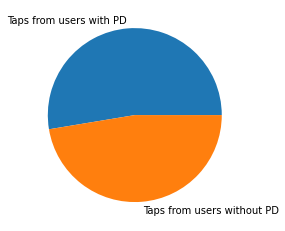

In [37]:
total_rows = all_userdata_df.shape
counts_parkinson = all_userdata_df[all_userdata_df["Parkinsons"] == 1].shape

x = np.array([counts_parkinson[0], total_rows[0]-counts_parkinson[0]])
label = ["Taps from users with PD", "Taps from users without PD"]
plt.pie(x, labels = label)
plt.show()

Text(0.5, 1.0, 'Parkinsons')

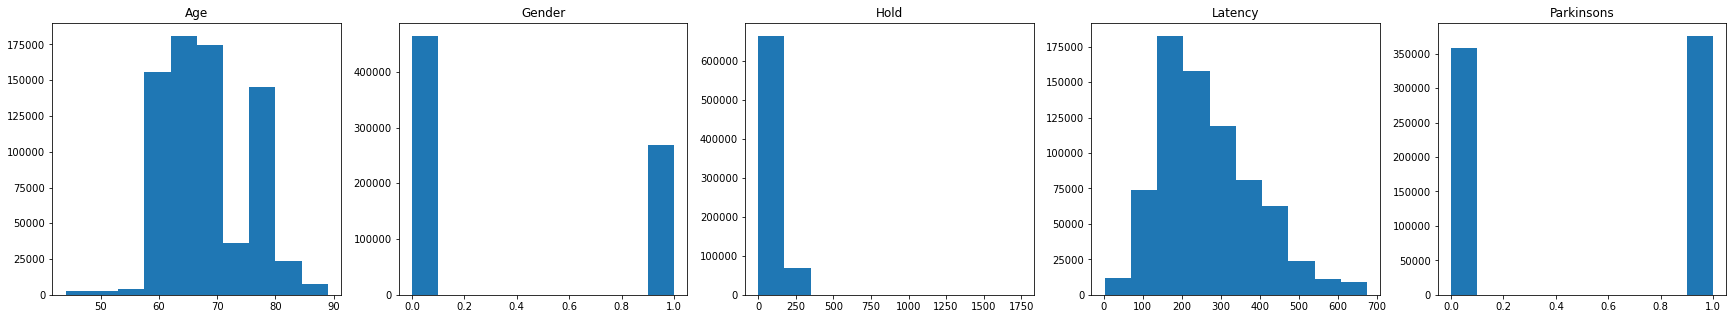

In [38]:

z_scores = stats.zscore(all_userdata_df)
abs_z_scores = np.abs(z_scores)

filtered_entries = (abs_z_scores < 3).all(axis=1)

all_userdata_df = all_userdata_df[filtered_entries]

# all_userdata_df.hist(bins = 10, figsize = (20,15), range = [0, 500])
fig, axs = plt.subplots(1, 5, figsize = (30,5))

axs[2].hist(all_userdata_df.Hold)
axs[2].set_title('Hold')
axs[3].hist(all_userdata_df.Latency)
axs[3].set_title('Latency')
axs[1].hist(all_userdata_df.Gender)
axs[1].set_title('Gender')
axs[0].hist(all_userdata_df.Age)
axs[0].set_title('Age')
axs[4].hist(all_userdata_df.Parkinsons)
axs[4].set_title('Parkinsons')

# # all_userdata_df.drop(all_userdata_df.loc[all_userdata_df['Hold']==812648.4].index, inplace=True)
# # all_userdata_df.drop(all_userdata_df.loc[all_userdata_df['Hold']==84773.4].index, inplace=True)
# # all_userdata_df.drop(all_userdata_df.loc[all_userdata_df['Hold']==4480.5].index, inplace=True)

# find = all_userdata_df[all_userdata_df.Hold > 3000]
# print(find)

In [39]:
x = all_userdata_df.iloc[:, :-1].values
y = all_userdata_df.iloc[:, -1].values

print(x)
print(y)

# ho diviso tutte le colonne (x) dal target parkinsons (y)

[[ 58.   78.1 312.5 ...   0.    0.    0. ]
 [ 58.   78.1 453.1 ...   0.    0.    0. ]
 [ 58.   62.5 414.1 ...   0.    0.    0. ]
 ...
 [ 70.  171.9 343.8 ...   0.    0.    0. ]
 [ 70.  132.8 312.5 ...   0.    0.    0. ]
 [ 70.  109.4 437.5 ...   0.    0.    0. ]]
[0 0 0 ... 1 1 1]


In [40]:

# splitto matrice x e array y in sottoinsiemi random di train e test, di dimensioni 4/5 e 1/5
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25)

graph = all_userdata_df.sample(n = 100)
x_graph = graph.iloc[:, 1:3].values
y_graph = graph.iloc[:, -1].values

# print(x_train)
# print(y_train)

# print(x_test)
# print(y_test)

# print(x_graph)
# print(y_graph)


In [41]:
# import collections
# print(len(y_train))
# new_parkinson = collections.Counter(y_train)[1]
# print(new_parkinson)


In [42]:
# prima del modello di classificazione faccio lo scaling
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_graph = scaler.fit_transform(x_graph)
#proviamo con questo scaler dopo possiamo provare quello normaliza
# len(x_train) 
# len(x_test) = 316643
# len(x_graph) = 100




In [43]:
# matrice di correlazione per curiosita

# import seaborn as sns
# corr = pd.concat([x, y], axis=1).corr()
# corr_values = corr.iloc[:,15].values
# print("Massima correlazione positiva con il target:", np.max(corr_values[0:corr_values.size-1]))
# print("Massima correlazione negativa con il target:", np.min(corr_values))
# print(pd.concat([x, y], axis=1).columns[abs(corr_values) < 0.01]) 

# plt.figure(figsize=(15, 16), dpi=160)
# sns.heatmap(pd.concat([x, y], axis=1).corr(), cmap="bwr")


0.7079205310535799
0.7080465161944866


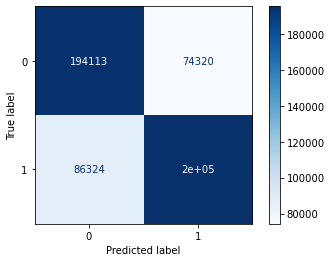

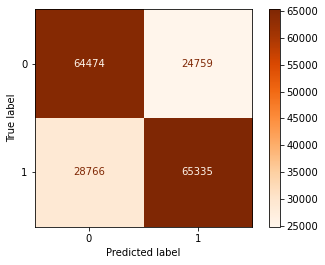

In [44]:
# Naive Bayes classification

classifierBAYES = GaussianNB()
classifierBAYES.fit(x_train, y_train)

y_pred_BAYES0 = classifierBAYES.predict(x_train)
y_pred_BAYES = classifierBAYES.predict(x_test)

CM_BAYES0 = confusion_matrix(y_train, y_pred_BAYES0)
PercBAYES0 = (CM_BAYES0[0,0]+CM_BAYES0[1,1])/CM_BAYES0.sum()

CM_BAYES = confusion_matrix(y_test, y_pred_BAYES)
PercBAYES = (CM_BAYES[0,0]+CM_BAYES[1,1])/CM_BAYES.sum()

cmd0 = ConfusionMatrixDisplay(CM_BAYES0)
cmd = ConfusionMatrixDisplay(CM_BAYES)
cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercBAYES0)
print(PercBAYES)

0.6317115787062205
0.6323049734364602


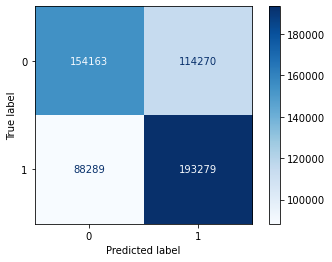

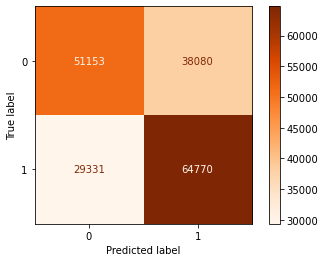

In [45]:

# qua si parte con il learning
# pero il ragazzo di Genova dice che x_train e x_test hanno troppe righe
# allora si riduce le dimensioni del dataset prendendo il 4% (applica test_size = 0.2 per due volte)

#############


classifierLogReg = LogisticRegression(random_state = 0)
classifierLogReg.fit(x_train, y_train)

#The algorithm has learnt on training set, now I will predict the outcomes on test set
y_pred_LogReg0 = classifierLogReg.predict(x_train)
y_pred_LogReg = classifierLogReg.predict(x_test)

# ogni riga e un'istanza della classe vera
# e la matrice TP FP TN FN
CM_LogReg0 = confusion_matrix(y_train, y_pred_LogReg0)
PercLogReg0 = (CM_LogReg0[0,0]+CM_LogReg0[1,1])/CM_LogReg0.sum()

CM_LogReg = confusion_matrix(y_test, y_pred_LogReg)
PercLogReg = (CM_LogReg[0,0]+CM_LogReg[1,1])/CM_LogReg.sum()
# print(CM_LogReg)
# print(CM_LogReg0)

# print(PercLogReg)
# print(PercLogReg0)

cmd0 = ConfusionMatrixDisplay(CM_LogReg0)
cmd = ConfusionMatrixDisplay(CM_LogReg)

cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercLogReg0)
print(PercLogReg)

#visual
# from matplotlib.colors import ListedColormap

# classifierLogReg_graph = LogisticRegression(random_state = 0)
# classifierLogReg_graph.fit(x_graph, y_graph)

# X_set, y_set = x_graph, y_graph
# X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
#                      np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
# plt.figure(1)
# plt.contourf(X1, X2, classifierLogReg_graph.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
#              alpha = 0.75, cmap = ListedColormap(('red', 'green')))
# plt.xlim(X1.min(), X1.max())
# plt.ylim(X2.min(), X2.max())
# for i, j in enumerate(np.unique(y_set)):
#     plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
#                 c = ListedColormap(('red', 'green'))(i), label = j)
# plt.title('Logistic Regression')
# plt.xlabel('Latency')
# plt.ylabel('Hold')
# plt.legend()
# plt.show()




0.8311403070176236
0.8308606150523089


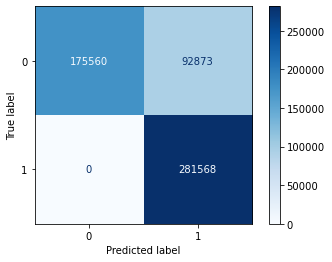

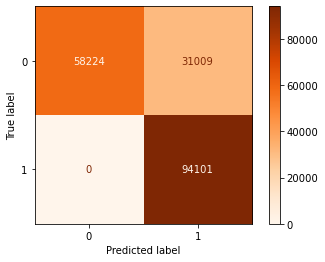

In [46]:
# Decision Tree classification

classifierTREE = DecisionTreeClassifier(criterion = 'entropy', splitter = "best", max_depth = 5, random_state = 0)
classifierTREE.fit(x_train, y_train)

# provare la profondita e capire perche

y_pred_TREE = classifierTREE.predict(x_test)
y_pred_TREE0 = classifierTREE.predict(x_train)

CM_TREE0 = confusion_matrix(y_train, y_pred_TREE0)
PercTREE0 = (CM_TREE0[0,0]+CM_TREE0[1,1])/CM_TREE0.sum()

CM_TREE = confusion_matrix(y_test, y_pred_TREE)
PercTREE = (CM_TREE[0,0]+CM_TREE[1,1])/CM_TREE.sum()

cmd0 = ConfusionMatrixDisplay(CM_TREE0)
cmd = ConfusionMatrixDisplay(CM_TREE)
cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercTREE0)
print(PercTREE)


0.9704000538180839
0.9494420020290836


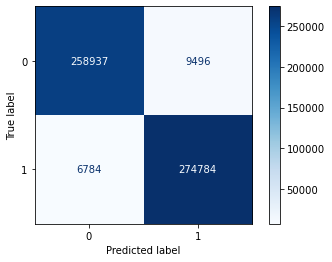

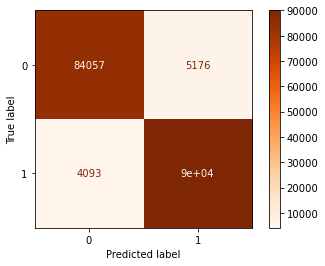

In [47]:
# Random Forest classification

classifierFOR = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifierFOR.fit(x_train, y_train)

y_pred_FOR0 = classifierFOR.predict(x_train)
y_pred_FOR = classifierFOR.predict(x_test)

CM_FOR0 = confusion_matrix(y_train, y_pred_FOR0)
PercFOR0 = (CM_FOR0[0,0]+CM_FOR0[1,1])/CM_FOR0.sum()

CM_FOR = confusion_matrix(y_test, y_pred_FOR)
PercFOR = (CM_FOR[0,0]+CM_FOR[1,1])/CM_FOR.sum()

cmd0 = ConfusionMatrixDisplay(CM_FOR0)
cmd = ConfusionMatrixDisplay(CM_FOR)
cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercFOR0)
print(PercFOR)

In [48]:
# metric = 'recall'
# n_folds = 5
# scores_dict = {}


In [49]:
# DIMINUIRE LA CARDINALITA DEL DATASET
x_train, x_test, y_train, y_test = train_test_split(x_test, y_test, test_size = 0.2)
x_train, x_test, y_train, y_test = train_test_split(x_test, y_test, test_size = 0.2)

0.8299867043943682
0.8358331060812654


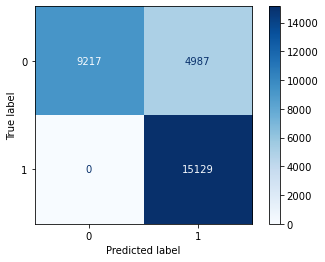

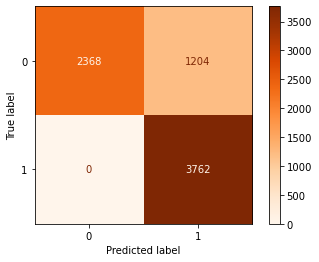

In [50]:
# Decision Tree classification
# rifaccio dopo il taglio

classifierTREE = DecisionTreeClassifier(criterion = 'entropy', splitter = "best", max_depth = 5, random_state = 0)
classifierTREE.fit(x_train, y_train)

# provare la profondita e capire perche

y_pred_TREE = classifierTREE.predict(x_test)
y_pred_TREE0 = classifierTREE.predict(x_train)

CM_TREE0 = confusion_matrix(y_train, y_pred_TREE0)
PercTREE0 = (CM_TREE0[0,0]+CM_TREE0[1,1])/CM_TREE0.sum()

CM_TREE = confusion_matrix(y_test, y_pred_TREE)
PercTREE = (CM_TREE[0,0]+CM_TREE[1,1])/CM_TREE.sum()

cmd0 = ConfusionMatrixDisplay(CM_TREE0)
cmd = ConfusionMatrixDisplay(CM_TREE)
cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercTREE0)
print(PercTREE)


0.9869771247400538
0.9196891191709845


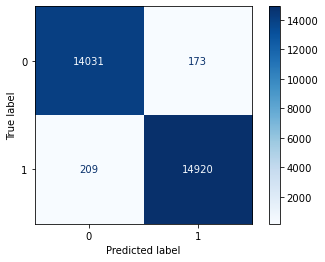

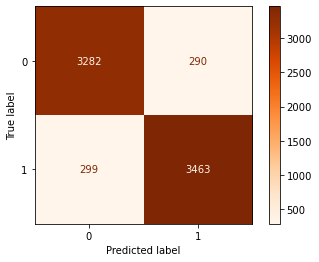

In [51]:
# Random Forest classification
# rifaccio dopo il taglio

classifierFOR = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifierFOR.fit(x_train, y_train)

y_pred_FOR0 = classifierFOR.predict(x_train)
y_pred_FOR = classifierFOR.predict(x_test)

CM_FOR0 = confusion_matrix(y_train, y_pred_FOR0)
PercFOR0 = (CM_FOR0[0,0]+CM_FOR0[1,1])/CM_FOR0.sum()

CM_FOR = confusion_matrix(y_test, y_pred_FOR)
PercFOR = (CM_FOR[0,0]+CM_FOR[1,1])/CM_FOR.sum()

cmd0 = ConfusionMatrixDisplay(CM_FOR0)
cmd = ConfusionMatrixDisplay(CM_FOR)
cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercFOR0)
print(PercFOR)

c:\Users\tagli\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


0.8918964988238502
0.8866921188982819


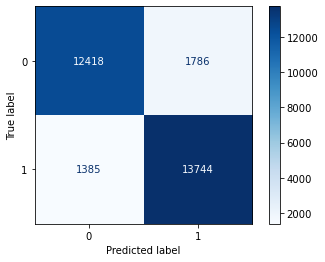

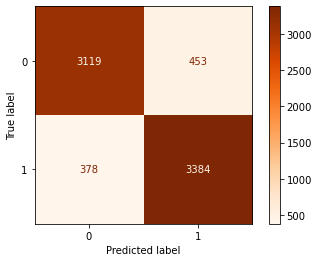

In [52]:
# altri metodi : chi piu ne ha piu ne metta

# Multiple Layer Perceptron
# -------------------------------------------------------------------


classifierMLPr = MLPClassifier(hidden_layer_sizes = (10, 10, 10), activation = "relu", max_iter=50) # relu act
# classifierMLPr = MLPClassifier(hidden_layer_sizes = (10, 10, 10), activation = "tanh", max_iter=50) # tanh act
# classifierMLPr = MLPClassifier(hidden_layer_sizes = (10, 10, 10), activation = "identity", max_iter=50) # identity act LUI FA CAGARE ATTENZIONE
# classifierMLPr = MLPClassifier(hidden_layer_sizes = (10, 10, 10), activation = "logistic", max_iter=50) # logistic act


classifierMLPr.fit(x_train, y_train)

y_pred_MLPr0 = classifierMLPr.predict(x_train)
y_pred_MLPr = classifierMLPr.predict(x_test)

CM_MLPr0 = confusion_matrix(y_train, y_pred_MLPr0)
PercMLPr0 = (CM_MLPr0[0,0] + CM_MLPr0[1,1])/CM_MLPr0.sum()

CM_MLPr = confusion_matrix(y_test, y_pred_MLPr)
PercMLPr = (CM_MLPr[0,0] + CM_MLPr[1,1])/CM_MLPr.sum()

cmd0 = ConfusionMatrixDisplay(CM_MLPr0)
cmd = ConfusionMatrixDisplay(CM_MLPr)
cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercMLPr0)
print(PercMLPr)

In [53]:
# ADABOOST v1


classifierADA = AdaBoostClassifier()

grid = dict()
grid['n_estimators'] = [200]
grid['learning_rate'] = [.001, .01, .1, 1]
# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
# define the grid search procedure
grid_search = GridSearchCV(estimator = classifierADA, param_grid = grid, n_jobs = -1, cv = cv, scoring = 'accuracy')
# execute the grid search
grid_result = grid_search.fit(x_train, y_train)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_ , grid_result.best_params_))
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.906124 using {'learning_rate': 1, 'n_estimators': 200}
0.715440 (0.005512) with: {'learning_rate': 0.001, 'n_estimators': 200}
0.818498 (0.007172) with: {'learning_rate': 0.01, 'n_estimators': 200}
0.875180 (0.006368) with: {'learning_rate': 0.1, 'n_estimators': 200}
0.906124 (0.005148) with: {'learning_rate': 1, 'n_estimators': 200}


0.9042375481539563
0.9029179165530407


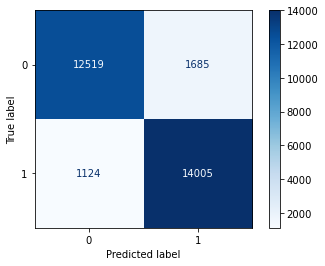

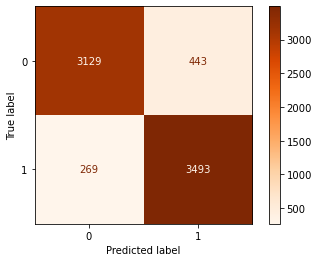

In [54]:
# ADABOOST v2


classifierAB = AdaBoostClassifier()
classifierAB.fit(x_train, y_train)

y_pred_AB0 = classifierAB.predict(x_train)
y_pred_AB = classifierAB.predict(x_test)

CM_AB0 = confusion_matrix(y_train, y_pred_AB0)
PercAB0 = (CM_AB0[0,0] + CM_AB0[1,1])/CM_AB0.sum()

CM_AB = confusion_matrix(y_test, y_pred_AB)
PercAB = (CM_AB[0,0] + CM_AB[1,1])/CM_AB.sum()

cmd0 = ConfusionMatrixDisplay(CM_AB0)
cmd = ConfusionMatrixDisplay(CM_AB)
cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercAB0)
print(PercAB)

0.80520233184468
0.8026997545677665


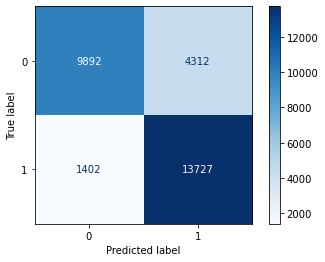

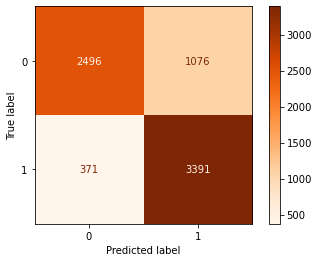

In [55]:
# SVM to fit algorithm

classifierSVC = SVC(kernel = 'rbf', random_state = 0)
classifierSVC.fit(x_train, y_train)

y_pred_SVMK0 = classifierSVC.predict(x_train)
y_pred_SVMK = classifierSVC.predict(x_test)

CM_SVMK0 = confusion_matrix(y_train, y_pred_SVMK0)
PercSVMK0 = (CM_SVMK0[0,0]+CM_SVMK0[1,1])/CM_SVMK0.sum()

CM_SVMK = confusion_matrix(y_test, y_pred_SVMK)
PercSVMK = (CM_SVMK[0,0]+CM_SVMK[1,1])/CM_SVMK.sum()

cmd0 = ConfusionMatrixDisplay(CM_SVMK0)
cmd = ConfusionMatrixDisplay(CM_SVMK)
cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercSVMK0)
print(PercSVMK)

0.9247605086421437
0.8910553586037633


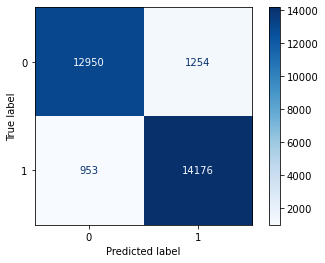

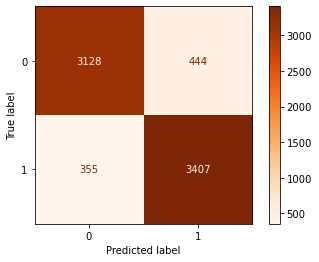

In [56]:
# KNN to fit algorithm

classifierKNN = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifierKNN.fit(x_train, y_train)

y_pred_KNN0 = classifierKNN.predict(x_train)
y_pred_KNN = classifierKNN.predict(x_test)

CM_KNN0 = confusion_matrix(y_train, y_pred_KNN0)
PercKNN0 = (CM_KNN0[0,0]+CM_KNN0[1,1])/CM_KNN0.sum()

CM_KNN = confusion_matrix(y_test, y_pred_KNN)
PercKNN = (CM_KNN[0,0]+CM_KNN[1,1])/CM_KNN.sum()

cmd0 = ConfusionMatrixDisplay(CM_KNN0)
cmd = ConfusionMatrixDisplay(CM_KNN)
cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercKNN0)
print(PercKNN)

0.8627825316196776
0.8560130897191165


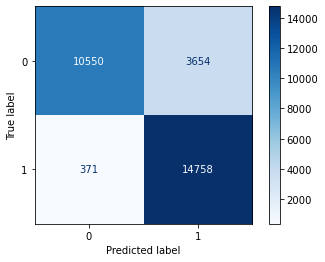

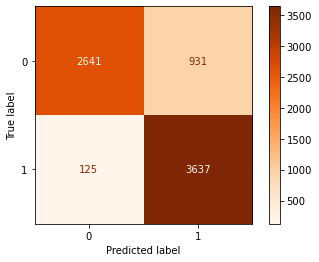

In [57]:
# Ensemble voting

Models = []
Models.append(('KNN', classifierKNN))
Models.append(('SVC', classifierSVC))
Models.append(('Tree', classifierTREE))
# Models.append(('Logistic', classifierLogReg))
# Models.append(('Bayes', classifierBAYES))
# by removing these last two classifiers, performances increase

ensemble = VotingClassifier(Models)
ensemble = ensemble.fit(x_train, y_train)

y_pred_ENS0 = ensemble.predict(x_train)
y_pred_ENS = ensemble.predict(x_test)

CM_ENS0 = confusion_matrix(y_train, y_pred_ENS0)
PercENS0 = (CM_ENS0[0,0]+CM_ENS0[1,1])/CM_ENS0.sum()

CM_ENS = confusion_matrix(y_test, y_pred_ENS)
PercENS = (CM_ENS[0,0]+CM_ENS[1,1])/CM_ENS.sum()

cmd0 = ConfusionMatrixDisplay(CM_ENS0)
cmd = ConfusionMatrixDisplay(CM_ENS)
cmd0.plot(cmap = "Blues")
cmd.plot(cmap = "Oranges")

print(PercENS0)
print(PercENS)

In [58]:
##### Parte dedicata alla visualizzazione (plot, grafici ecc)

# mago forest visualization
# from matplotlib.colors import ListedColormap

# classifierFOR_graph = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
# classifierFOR_graph.fit(x_graph, y_graph)

# X_set, y_set = x_graph, y_graph
# X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
#                      np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
# plt.figure(4)
# plt.contourf(X1, X2, classifierFOR_graph.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
#              alpha = 0.75, cmap = ListedColormap(('red', 'green')))
# plt.xlim(X1.min(), X1.max())
# plt.ylim(X2.min(), X2.max())
# for i, j in enumerate(np.unique(y_set)):
#     plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
#                 c = ListedColormap(('red', 'green'))(i), label = j)
# plt.title('Random Forest')
# plt.xlabel('Latency')
# plt.ylabel('Hold')
# plt.legend()
# plt.show()

manca:
parte di plot
conclusioni
descrizioni metodi
descrizione parte preprocessing e outlier
possibile feature selection

fare notebook con parti in md